In [152]:
import cv2
import os
import subprocess
from astropy.io import fits,ascii
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.table import Table
import multiprocessing
from astropy.table import Table
import numpy as np

In [3]:
#os.chdir("/home/alam/task/task-inspecity/source-ex")

(2080, 3072)


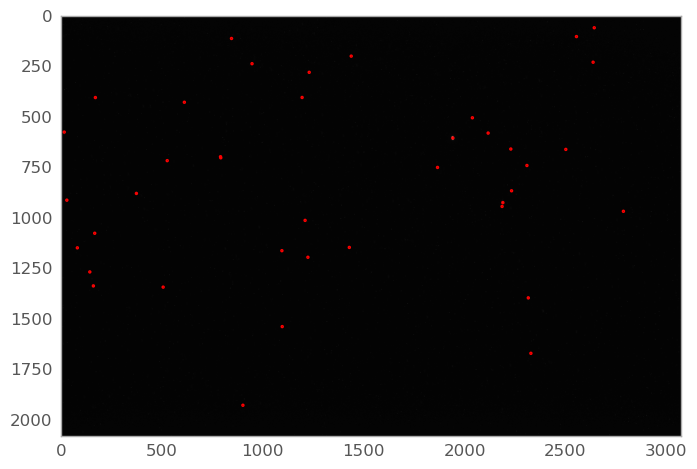

In [199]:
sext1 = ascii.read('/home/alam/task/task-inspecity/source-ex/test.cat',format = 'sextractor')
sext1.sort(['MAG_ISO'])
sext2 = sext1[0:40]
sextx = sext2['X_IMAGE']
sexty = sext2['Y_IMAGE']
sex_mag = sext2['MAG_ISO']
sext_x = (sextx-1536)*0.27   # queda en mm centrada en (0,0)
sext_y = (sexty-1040)*0.27
#hdul = fits.open('/home/alam/task/task-inspecity/source-ex/img-0001.fits')
#image_data = hdul[0].data



image_data = fits.getdata('/home/alam/task/task-inspecity/source-ex/img-0001.fits',ext = 0)
print(image_data.shape)
plt.figure()
plt.imshow(image_data,cmap = 'gray')
plt.grid(False)

for x_coord, y_coord in zip(sextx, sexty):
    circle = plt.Circle((x_coord, y_coord), radius=5, color='r', fill=False)
    plt.gca().add_patch(circle)

plt.show()


In [226]:
sext1

X_IMAGE,Y_IMAGE,MAG_ISO
pix,pix,mag
float64,float64,float64
1941.6967,604.5889,-17.4031
2189.5938,924.6875,-16.5402
373.9201,879.1801,-15.6657
160.767,1337.4337,-15.526
2315.7427,1396.7078,-15.5001
2116.6904,580.2325,-15.0139
170.688,404.165,-15.0019
1194.9434,403.8178,-14.9876


In [201]:
ascii.write([sext_x, sext_y, sex_mag], '/home/alam/task/task-inspecity/sex_t', delimiter = ' ', format = 'no_header',overwrite=True, formats = {'col0':'% 15.10f', 'col1':'% 15.10f', 'col2':'% 15.10f'})

In [202]:
ra_dec = [(ra, dec) for ra in range(0, 360, 5) for dec in range(-80, 90, 5)]

def call_match(ra_dec):
    RA1, DEC1 = ra_dec
    # Transform RA and DEC in string and make the path for catalog.
    path_catalog1 = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Projected' +  '/cat_RA_'
    path_catalog2 = str(RA1) + '_DEC_' + str(DEC1)
    path_catalog3 = path_catalog1 + path_catalog2
    # Do Match.
    parameters1 = 'matchrad=3.0 trirad=0.001 nobj=40'
    command = 'match ' + '/home/alam/task/task-inspecity/sex_t' + ' 0 1 2 ' + path_catalog3 + ' 0 1 2 ' + parameters1
    
    results = subprocess.run(command, shell=True, capture_output=True, text=True)
    stdout_str = results.stdout
    return stdout_str

pool = multiprocessing.Pool(2)
results = pool.map(call_match, ra_dec)

In [203]:
results

['TRANS: a=-7.764240210e-01 b=-1.836616023e-03 c=4.344067015e-04 d=4.257974212e-01 e=-3.445730457e-04 f=-2.160866789e-03 sig=7.5101e-02 Nr=8 Nm=8 sx=1.5086e-01 sy=2.7639e-01 \n',
 'TRANS: a=-5.500127842e-01 b=-3.630989652e-03 c=-3.989308655e-03 d=6.359499575e-01 e=-9.440268590e-04 f=-3.698079656e-04 sig=2.7465e-02 Nr=9 Nm=9 sx=9.9493e-02 sy=1.2087e-01 \n',
 'TRANS: a=-1.645198648e-02 b=-1.356924905e-03 c=5.537418525e-04 d=8.801808666e-01 e=-1.985401863e-04 f=2.504541822e-03 sig=3.1378e-02 Nr=6 Nm=6 sx=1.9280e-01 sy=1.7716e-01 \n',
 'TRANS: a=1.377863209e-01 b=1.092872442e-03 c=1.327251767e-03 d=4.157127244e-01 e=-8.437604489e-05 f=3.611432578e-03 sig=2.1423e-02 Nr=6 Nm=7 sx=2.3676e-01 sy=1.7961e-01 \n',
 'TRANS: a=-7.086029392e-01 b=4.720303227e-04 c=-4.983547832e-03 d=-4.685134209e-02 e=1.697929664e-03 f=1.733462766e-03 sig=2.7960e-02 Nr=10 Nm=12 sx=1.7282e-01 sy=2.3488e-01 \n',
 'TRANS: a=4.531870032e-01 b=4.755017659e-03 c=8.747042256e-03 d=-1.440027724e-01 e=4.652183689e-03 f=5.086

In [204]:
match1_table1 = Table(names=('RA_center', 'DEC_center', 'sig', 'Nr'))

In [205]:
for i, item in enumerate(results):
    RA1, DEC1 = ra_dec[i]
    
    
    match1_aux1 = item.find('sig=')
    match1_aux2 = item.find('Nr=')
    match1_auxsig1 = item[match1_aux1+4:match1_aux1+25]
    match1_auxnr1 = item[match1_aux2+3:match1_aux2+10]
    match1_sig1 = match1_auxsig1.split(' ', 1)[0]
    match1_nr1 = match1_auxnr1.split(' ', 1)[0]
    if match1_sig1 and match1_nr1:  # Check if both 'sig' and 'Nr' values are non-empty
            match1_table1.add_row([str(RA1), str(DEC1), match1_sig1, match1_nr1])

In [206]:
match1_table1.sort('Nr',reverse=True)

In [207]:
match1_table1

RA_center,DEC_center,sig,Nr
float64,float64,float64,float64
225.0,-25.0,0.018313,25.0
175.0,-60.0,0.057847,24.0
245.0,15.0,0.057204,24.0
110.0,-45.0,0.015383,23.0
240.0,-20.0,0.050207,23.0
100.0,-25.0,0.019944,23.0
105.0,-25.0,0.01854,23.0
35.0,35.0,0.045206,22.0
100.0,-20.0,0.016329,22.0


In [208]:
match1_RA = int(match1_table1[0][0])
match1_DEC = int(match1_table1[0][1])
path_catalog1 = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Projected' +  '/cat_RA_'
path_catalog6 = str(match1_RA) + '_DEC_' + str(match1_DEC)
path_catalog7 = path_catalog1 + path_catalog6
parameters1 = 'matchrad=3.0 trirad=0.001 nobj=40'
Match2 = 'match ' + '/home/alam/task/task-inspecity/sex_t' + ' 0 1 2 ' + path_catalog7 + ' 0 1 2 ' + parameters1
results = subprocess.run(Match2, shell=True, capture_output=True, text=True)
stdout_str = results.stdout
stdout_str

'TRANS: a=-2.343518735e-02 b=-3.254579884e-03 c=1.580414786e-03 d=-6.293657912e-01 e=-1.013715530e-03 f=3.340032091e-03 sig=1.8313e-02 Nr=25 Nm=25 sx=1.1085e-01 sy=8.5301e-02 \n'

In [209]:
match1_aux5 = stdout_str.find('a=')
match1_aux6 = stdout_str.find('b=')
match1_aux7 = stdout_str.find('c=')
match1_aux8 = stdout_str.find('d=')
match1_aux9 = stdout_str.find('e=')
match1_aux10 = stdout_str.find('f=')
match1_aux11 = stdout_str.find('sig=')
match1_aux12 = stdout_str.find('Nr=')
match1_aux13 = stdout_str.find('Nm=')
match1_auxa1 = stdout_str[match1_aux5+2:match1_aux5+25]
match1_auxb1 = stdout_str[match1_aux6+2:match1_aux6+25]
match1_auxc1 = stdout_str[match1_aux7+2:match1_aux7+25]
match1_auxd1 = stdout_str[match1_aux8+2:match1_aux8+25]
match1_auxe1 = stdout_str[match1_aux9+2:match1_aux9+25]
match1_auxf1 = stdout_str[match1_aux10+2:match1_aux10+25]
match1_auxsig3 = stdout_str[match1_aux11+4:match1_aux11+25]
match1_auxnr3 = stdout_str[match1_aux12+3:match1_aux12+10]
match1_auxnm3 = stdout_str[match1_aux13+3:match1_aux13+10]
match1_sig3 = match1_auxsig3.split(' ', 1)[0]
match1_nr3 = match1_auxnr3.split(' ', 1)[0]
match1_nm3 = match1_auxnm3.split(' ', 1)[0]
match1_auxa2 = match1_auxa1.split(' ', 1)[0]
match1_auxb2 = match1_auxb1.split(' ', 1)[0]
match1_auxc2 = match1_auxc1.split(' ', 1)[0]
match1_auxd2 = match1_auxd1.split(' ', 1)[0]
match1_auxe2 = match1_auxe1.split(' ', 1)[0]
match1_auxf2 = match1_auxf1.split(' ', 1)[0]
match1_a = float(match1_auxa2)
match1_b = float(match1_auxb2)
match1_c = float(match1_auxc2)
match1_d = float(match1_auxd2)
match1_e = float(match1_auxe2)
match1_f = float(match1_auxf2)

In [210]:
match1_a

-0.02343518735

In [211]:
match1_T = np.array([(match1_a), (match1_d)])
match1_R = np.array([(match1_b, match1_c), (match1_e, match1_f)])

In [212]:
match1_T

array([-0.02343519, -0.62936579])

In [213]:
match1_x_pix = 0
match1_y_pix = 0
match1_X_pix = np.array([(match1_x_pix), (match1_y_pix)])
match1_X_cielo = match1_T + np.dot(match1_R, match1_X_pix)
match1_RA_new = match1_X_cielo[0]
match1_DEC_new = match1_X_cielo[1]
match1_roll_r = np.arctan2(match1_c, match1_b)
match1_roll_d = (180/np.pi)*match1_roll_r

In [214]:
f = 400 #mm
dep1_xi = match1_RA_new/f
dep1_eta = match1_DEC_new/f
dep1_RA_r = match1_RA*(np.pi/180)
dep1_DEC_r = match1_DEC*(np.pi/180)
dep1_arg1 = np.cos(dep1_DEC_r) - dep1_eta*np.sin(dep1_DEC_r)
dep1_arg2 = np.arctan(dep1_xi/dep1_arg1)
dep1_alpha1 = match1_RA + (180/np.pi)*dep1_arg2
dep1_arg3 = np.sin(dep1_arg2)
dep1_arg4 = dep1_eta*np.cos(dep1_DEC_r) + np.sin(dep1_DEC_r)
dep1_delta1 = (180/np.pi)*np.arctan((dep1_arg3*dep1_arg4)/dep1_xi)

In [215]:
cat_nor = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Normal/'
new_cat1 = cat_nor + 'cat_RA_' + str(match1_RA) + '_DEC_' + str(match1_DEC)
new_cat2 = ascii.read(new_cat1)
np_matched_B1 = ascii.read('/home/alam/task/task-inspecity/notebooks/matched.mtB')
np_matched_B2 = ascii.read('/home/alam/task/task-inspecity/notebooks/matched.unB')
np_aux1 = np_matched_B1[0][0]
np_aux2 = np_matched_B2[0][0]
# Define el menor numero como el contador de inicio para la busqueda.
if np_aux1>np_aux2:
    np_cont1 = np_aux2
else:
    np_cont1 = np_aux1
# Crea nueva tabla con las estrellas que hizo match.
np_table1 = Table([[], [], []])
# Busqueda de estrellas para agregar a tabla.
for i in range(0, len(np_matched_B1), 1):
    np_cont2 = np_matched_B1[i][0] - np_cont1
    np_table1.add_row([new_cat2[np_cont2][0], new_cat2[np_cont2][1], new_cat2[np_cont2][2]])

In [216]:
cat_tran1 = Table([[], [], []])
conv1_largo1 = len(np_table1)

for index in range (0, conv1_largo1):
    conv1_alpha_d = np_table1[index][0]
    conv1_delta_d = np_table1[index][1]
    conv1_mag = np_table1[index][2]
    
    conv1_alpha_r = (np.pi/180)*conv1_alpha_d
    conv1_delta_r = (np.pi/180)*conv1_delta_d
    conv1_alpha_0_r = (np.pi/180)*dep1_alpha1
    conv1_delta_0_r = (np.pi/180)*dep1_delta1
    
    conv1_xi_up = np.cos(conv1_delta_r)*np.sin(conv1_alpha_r - conv1_alpha_0_r)
    conv1_xi_down = np.sin(conv1_delta_0_r)*np.sin(conv1_delta_r) + np.cos(conv1_delta_0_r)*np.cos(conv1_delta_r)*np.cos(conv1_alpha_r - conv1_alpha_0_r)
    conv1_xi = conv1_xi_up/conv1_xi_down
    
    conv1_eta_up = np.cos(conv1_delta_0_r)*np.sin(conv1_delta_r) - np.sin(conv1_delta_0_r)*np.cos(conv1_delta_r)*np.cos(conv1_alpha_r - conv1_alpha_0_r)
    conv1_eta_down = conv1_xi_down
    conv1_eta = conv1_eta_up/conv1_eta_down
    
    conv1_xi_mm = f*conv1_xi
    conv1_eta_mm = f*conv1_eta
    
    cat_tran1.add_row([conv1_xi_mm, conv1_eta_mm, conv1_mag])

In [217]:
cat_tran1

col0,col1,col2
float64,float64,float64
-201.25105629316823,-246.5314502605057,3.91
-184.38075576359614,-224.39285357357167,2.17
15.022302817276625,-175.47329060925352,3.87
-23.082493139897252,-164.7607233276888,2.3
-83.49656116899492,-172.60038564821832,2.55
29.945444648830716,-143.53583579140277,3.37
-81.66836717497567,-151.5522150377147,3.87
-1.947036398467202,-130.31000362466742,2.68
-33.19958177847338,-124.0547291613143,2.31


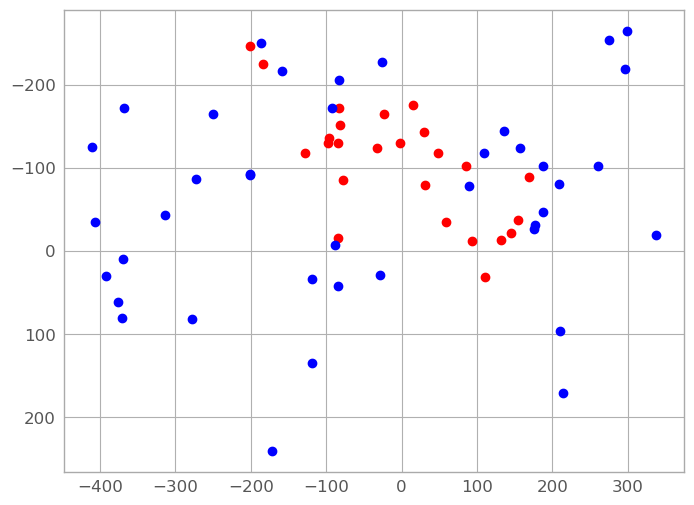

In [222]:
plt.scatter(cat_tran1['col0'], cat_tran1['col1'], color = 'r')
coordinates_mat = []
with open('/home/alam/task/task-inspecity/sex_t', 'r') as file:
        for line in file:
            # Split the line into x and y coordinates (assuming space-separated)
            x, y ,z= map(float, line.split())
            coordinates_mat.append([x, y])
coordinates_mat = [tuple(array) for array in coordinates_mat]

x_coords_mat = [point[0] for point in coordinates_mat]
y_coords_mat = [point[1] for point in coordinates_mat]
plt.gca().invert_yaxis()
plt.scatter(x_coords_mat, y_coords_mat, color='b')

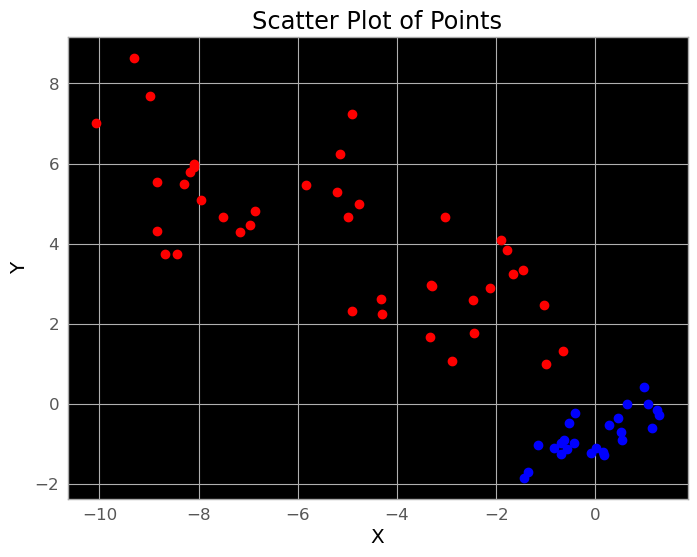

In [219]:
coordinates_img = []
coordinates_mat = []


with open('/home/alam/task/task-inspecity/sext', 'r') as file:
    for line in file:
        
        x, y,z = map(float, line.split())
        transformed_coordinate = match1_T + np.dot(np.array([[x, y]]), match1_R)
        
        coordinates_img.append(transformed_coordinate)
with open('/home/alam/task/task-inspecity/notebooks/matched.mtA', 'r') as file:
        for line in file:
            # Split the line into x and y coordinates (assuming space-separated)
            _, x, y ,z= map(float, line.split())
            coordinates_mat.append([x, y])

coordinates_img = [tuple(array.squeeze()) for array in coordinates_img]
coordinates_mat = [tuple(array) for array in coordinates_mat]
plt.figure()





x_coords = [point[0] for point in coordinates_img]
y_coords = [point[1] for point in coordinates_img]

x_coords_mat = [point[0] for point in coordinates_mat]
y_coords_mat = [point[1] for point in coordinates_mat]

# Plot the points
plt.scatter(x_coords, y_coords, color='r')
plt.scatter(x_coords_mat, y_coords_mat, color='b')
plt.gca().set_facecolor('black')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Points')
plt.grid(True)
plt.show()


In [220]:
coordinates_mat


[(-1.4501287, -1.8598372),
 (-1.3649334, -1.6956107),
 (0.1816494, -1.2852432),
 (-0.0838374, -1.2378402),
 (-0.7008377, -1.2590334),
 (0.1493894, -1.1958699),
 (-0.5670856, -1.1353988),
 (0.0061987, -1.1088482),
 (-0.4308184, -0.9744009),
 (-0.8313772, -1.1127469),
 (-0.638348, -0.9028695),
 (0.5388718, -0.9162055),
 (-0.7043743, -0.9711657),
 (-1.1521621, -1.0360391),
 (0.5054774, -0.7114783),
 (-0.529409, -0.4901768),
 (0.2789444, -0.5333144),
 (1.1404218, -0.6018164),
 (0.4522586, -0.3568238),
 (1.287324, -0.2844696),
 (1.2408673, -0.1686068),
 (0.6275264, 0.0008983),
 (-0.4118292, -0.232286),
 (1.0630724, -0.0133031),
 (0.9847369, 0.4288429)]